<div style="text-align:center;">
  <img src="https://github.com/MolSSI-Education/iqb-2025/blob/main/images/molssi_main_outline.png?raw=true" style="display: block; margin: 0 auto; max-height:325px;">
</div>

# Preparing Molecules and Proteins for Docking
*This tutorial was created by Levi Naden (Software Scientist) at The Molecular Sciences Software Institue for the [Cheminformatic-Driven Molecular Docking Workshop](https://pdb101.rcsb.org/news/67d9853eaddf75595bd158f7) held as a Crash Course with the Institute for Quantitative Biomedicine (IQB) and the Protein Data Bank (RCSB).*

*Special thanks to Jessica Nash and Pat Walters for code samples and alternate tool suggestions that helped make up this notebook.*

*This notebook is Part 3 of 4 in the notebook series.*


In [ ]:
# @title Overview
%%html
<style>
div.alert {
    color: #0056b3;
    background-color: #d9edf7;
    border-left: 5px solid #31708f;
    padding: 0.5em;
    font-size: 1.25em;
    line-height: 1.5;
}
div.alert ul {
    margin: 0.5em 0;
}
div.alert li {
    margin-bottom: 0.5em;
}
</style>

<div class="alert alert-block alert-info">
    <strong>Questions:</strong>
    <ul>
        <li>Why can't we just go from RCSB files to Docking?</li>
        <li>What are the steps to take to ensure the molecule(s) and prtiens are ready?</li>
        <li>What are steps we can optionally perform to get better or more tailored results?</li>
    </ul>

    <strong>Objectives:</strong>
    <ul>
        <li>Learn about the "missing" information in molecular structure files</li>
        <li>Learn how to use a specific set of tools (among many) to prepare your files</li>
        <li>Understand nuance of the programs we work with to modify our preparation workflow</li>
    </ul>
</div>

This notebook will walk you through the process for going from RCSB files crystallographic data to docking-ready input files. The structures from the RCSB, and the corresponding files, are incomplete for the purposes of Docking (and molecular mechanics simulations generally). We'll walk through both the programmatic and visual issues with the protein and molecule files, and explicitly show what data are missing.

For this notebook, you'll install one particular set of tools for this prep workflow, but many are available and some are linked throughout this lesson.


# Set Up

Before going into any details, we'll be installing all the packages we need for this notebook. Specifically for the actual prep workflow we'll install:
* `PDBFixer`
* `MDAnalysis`
* `RDKit`
* `OpenMM` (and `OpenMMForceFields`)
* `OpenBabel`
* `Scrubber` (package: "`molscrub`")

We'll also install a few helper packages for visualization  and analysis. These are not explicitly needed for the workflow, but will aid in seeing what we are doing.

In [1]:
# Initial setup to enable Conda installable packages through CoLab
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


In [1]:
# Install our main workflow packages, this should take about a minute
%%capture output
!conda install -c conda-forge rdkit pdbfixer openmm openmmforcefields mdanalysis molscrub

In [2]:
# Install OpenBabel into the system as well
# OpenBabel is also available through Conda-Forge and PyPI (pip), but we wanted to show that you need not be limited by where a package comes from, just get it.
%%capture output
!apt install openbabel

In [3]:
# Install our visual renderer for the workbook.
%%capture output
!pip install py3Dmol

## Downloading Protein Structure Files

First and foremost, we need a protein to work with. We're going to look at the [SARS-CoV-2 3CL Protease structure of 7LME from the RCSB](https://www.rcsb.org/structure/7LME).

<div style="text-align:center;">
  <img src="https://cdn.rcsb.org/images/structures/7lme_assembly-1.jpeg?raw=true" style="display: block; margin: 0 auto; max-height:200px;">
</div>

Image from RCSB

We'll start by downloading this using the Python built-in `requests` package to make a `GET` REST request for the file. Effectively, this is our Python interpreter asking the RCSB site for a file directly at a specific location, a URL in this case. You can try this in your browser too! If you download or visit the page: https://files.rcsb.org/download/7LME.pdb, you'll get this exact text file; we're just doing it programmatically.

For our molecule, we know what ligand is bound to the structure from the RCSB page, `Y6J`, and we'll extract that as part of the process.

Note: You don't have to know the terminology of HTTP methods such as `GET` for this course, but it's helpful to know REST APIs are how most websites serve their information.


In [4]:
import os
import requests

pdb_id = "7LME" # The Protein ID we're looking at

# Start by making a directory for us to work in and stage our intermediate files
protein_directory = "docking_files"
protein_filename = f"{pdb_id}.pdb"
protein_filepath = os.path.join(protein_directory, protein_filename)
# Actually make the directory, the exist_ok flag lets the command execute even if the folder already exists. It does NOT overwrite existing data.
os.makedirs(protein_directory, exist_ok=True)

In [5]:
# Download the protein file
print(f"Downloading protein {pdb_id}...")
protein_url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
# Dont break the RCSB!
protein_url = f"https://raw.githubusercontent.com/MolSSI-Education/iqb-2025/refs/heads/main/data/{pdb_id}.pdb"
# Send the request and save the returned JSON blob as a variable
protein_request = requests.get(protein_url)
protein_request.raise_for_status() # Check for errors

In [6]:
# Save the actual text of the returned JSON blob as the PDB file we're used to
with open(protein_filepath, "w") as f:
    f.write(protein_request.text)
print(f"Saved protein to {protein_filepath}")

Saved protein to docking_files/7LME.pdb


## Visualizing the raw PDB File

We've downloaded our file from the RCSB, let's take a look at what we have and identify some issues for docking.

In [7]:
import py3Dmol
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read())
v.setStyle({'chain':'A'}, {'cartoon': {'color': '#0e9674'}})
v.setStyle({'chain':'B'}, {'cartoon': {'color': '#c46225'}})
v.zoomTo({'model':0})
v.rotate(90, "z")
v.rotate(-25, "y")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

The rendered molecule rotation and colors should be approximately  the same as the image from the RCSB's page.

On its face, it looks good. But let's add a few small changes to how we're doing the rendering to see more.

In [8]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read())
v.setStyle({'chain':'A'}, {'cartoon': {'color': '#0e9674'}})
v.setStyle({'chain':'B'}, {'cartoon': {'color': '#c46225'}})
# Selecting HETATM
v.setStyle({'hetflag': True}, {'stick': {'color': 'spectrum'}})
# Selecting objects with no bonds, i.e. water
v.setStyle({"bonds": 0},{"sphere":{"radius":0.5}})
v.zoomTo({'model':0})
v.rotate(90, "z")
v.rotate(-25, "y")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

You can see from the render that py3Dmol is rendering much more than just the dimer and its chains. There is some of this present inside the RCSB image as well, but here we have much more. Before we delve into exactly why we can't just use this for docking, let's cover what we actually need for a docking run:

* Atomistic level coordinates of receptor (here: protein)
* Connectivity of receptor (*can* be inferred, not always)
* Polar hydrogen and partial charges for receptor
* Where on the receptor we want to dock
* Atomistic level coordinates of ligand (here: small molecule)
* Partial charge and protonation states for ligand
* Descriptor of how atoms interact with each other

This may seem like a daunting list to compile from just a PDB file, but the software we're using makes many of these steps automatic for us.

In [ ]:
# @title
%%html
<style>
div.info { /* Based on Bootstrap Secondary Alert */
    color: #0c5460; /* Darker shade of blue for text */
    background-color: #d1ecf1; /* Light blue background */
    border-left: 5px solid #459db9; /* Bright blue border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="info">

<strong>Note: Not all docking needs all of these items</strong>

<p>This list is not fully accurate for shape-based docking; this workshop focuses on force/physics/simulation-based docking.

</div>

## Building Atomistic Receptor Model

Only looking at the render above, it's not immediately  obvious if we have all the coordinates. One way we can look at this is by checking the PDB file we downloaded. The box below loads the file we pulled down here, but you can use any editor you like to view the file.

In [10]:
from IPython.display import display, HTML

def render_text(text_blob):
  # Helper function for displaying text in Jupyter Notebooks in a scrollable object
  html = f"""
      <div style="height:400px; overflow:auto;">
          <pre>{text_blob}</pre>
      </div>
      """
  display(HTML(html))


render_text(protein_request.text)

Searching for the word "missing" shows at `REMARK` 465 and 470 that there are missing residues and atoms respectively. If we were doing shape-based docking, we might be able to get away with not having those residues if they don't contribute to the docking site, but is that a risk we really want to take? And we're not doing shape-based docking anyways, so we need those residues and atoms.

For instance, let’s look at the tyrosines in our molecule to show the problem.

In [11]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read())
v.setStyle()  # Clear all other styles
# Select all tyrosines that are not our problematic one
v.setStyle({'resn': 'TYR', 'not': {'resi': 154}}, {"stick": {"radius":.1, 'color':'blue'}})
# Missing atoms tyrosine
v.setStyle({'resi': 154}, {"stick": {"radius":.1, 'color':'red'}})
v.zoomTo({'model':0})
v.rotate(90, "z")
v.rotate(-25, "y")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

As you can see, those red residues are not fully atomistic tyrosines. That is something we'll have to fix.

Beyond just missing and incomplete residues, there are atoms in our PDB file which are simply not the receptor (protein). Specifically the crystallographic waters and the bound ligand in the PDB.

In [12]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read())
# Select ligand
v.setStyle({'hetflag': True, 'not':{'resname': 'HOH'}}, {'stick': {'color': 'spectrum'}})
# Select waters
v.setStyle({'resn': 'HOH', 'elem': 'O'}, {"sphere": {"radius":0.5, 'color':'red'}})
v.setStyle({'resn': 'HOH', 'elem': 'H'}, {"sphere": {"radius":0.5, 'color':'blue'}})
v.zoomTo({'model':0})
v.rotate(90, "z")
v.rotate(-25, "y")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

The rendering above shows that there are two ligands (stick representation) and many crystallographic waters (red dots). We expect there to be two bound ligands here that are roughly in symmetric locations because this is a dimer structure made of two chains.

Since we're exploring docking of different molecules in the binding sites, we're going to want to remove the currently present ligand so we can test other ones. We're also going to want to remove the crystallographic waters as they usually (not always) contribute to binding and will slow down our docking procedure. We'll also only be picking one of the binding sites (specifically the pocket in "Chain A") to reduce computational time.

## Cleaning the Receptor PDB Structure

The good news for most of the issues with the receptor structure is its a regular protein with standard residues. We've studied those and can fill in the missing information reliably.

For this workshop, we're going to be using a tool from the OpenMM Library called `PDBFixer` which is a tool that you can use to "fix" PDB files and prepare them for physics-based calculations. There are many other tools which can do these steps for you as well, but we're keeping within the OpenMM ecosystem of tools as an example of a way to approach a docking pipeline.

Examples of other tools to fix PDB structures are
[Modeller](https://salilab.org/modeller/),
[Amber's LEaP](https://ambermd.org/tutorials/pengfei/), and
[GalaxyFill (which is used by CHARMM-GUI)](https://seoklab.github.io/GalaxyFill/). Others also exist, so find the one that works for you.

We could have instructed that everyone should just "run these commands" since the protein is regular in its construction, but understanding why the commands are needed is important for novel research and issues which may arise in your own works. We'll see this at the end when we jump a bit ahead to look at the impact some of our choice made.

In [13]:
# Load the PDB into the PDBFixer class
from pdbfixer import PDBFixer
fixer = PDBFixer(filename=f"{protein_directory}/{pdb_id}.pdb")

Next we're going to solve the missing residues problem through the `findMissingResidues` method. This doesn't actually do anything to the structure, yet, its just compiling a list of atoms and coordinates on each chain that it *will* add when we call the corresponding command. That way, the user has the option to customize what is "fixed" on the protein.

In [14]:
fixer.findMissingResidues()
fixer.missingResidues

{(0, 304): ['PHE', 'GLN'], (1, 305): ['GLN']}

You can see that our list of missing residues matches the one in the `REMARK` section of the base PDB file.

Next we're going to identify any non-standard residues in our structure as well as provide suggested replacements. We'll also be issuing the command to make the suggested substitutions. You can customize what is substituted by modifying the `nonstandardResidues` attribute, or do mutations with `applyMutations`. Neither are required for this structure, but helpful to have in your pipeline as this can allow you to substitute residues.

In [15]:
fixer.findNonstandardResidues()
print(fixer.nonstandardResidues)
fixer.replaceNonstandardResidues()

[]


Next, we'll strip out all of the crystallographic waters and the ligands from our structure by telling `PDBFixer` to remove the "heterogen" atoms. We'll also see a list of things which have been removed from the structure. You may notice that `PDBFixer` notes a Chain 2, 3, and 4 instead of Chain A, B as present in the PDB file. That is because `PDBFixer` distinguishes "chains" as atom groupings for bookkeeping purposes, but correctly will reassemble them in the topology at the end.

In [16]:
fixer.removeHeterogens(keepWater=False)

[<Residue 609 (Y6J) of chain 2>,
 <Residue 610 (Y6J) of chain 3>,
 <Residue 611 (HOH) of chain 4>,
 <Residue 612 (HOH) of chain 4>,
 <Residue 613 (HOH) of chain 4>,
 <Residue 614 (HOH) of chain 4>,
 <Residue 615 (HOH) of chain 4>,
 <Residue 616 (HOH) of chain 4>,
 <Residue 617 (HOH) of chain 4>,
 <Residue 618 (HOH) of chain 4>,
 <Residue 619 (HOH) of chain 4>,
 <Residue 620 (HOH) of chain 4>,
 <Residue 621 (HOH) of chain 4>,
 <Residue 622 (HOH) of chain 4>,
 <Residue 623 (HOH) of chain 4>,
 <Residue 624 (HOH) of chain 4>,
 <Residue 625 (HOH) of chain 4>,
 <Residue 626 (HOH) of chain 4>,
 <Residue 627 (HOH) of chain 4>,
 <Residue 628 (HOH) of chain 4>,
 <Residue 629 (HOH) of chain 4>,
 <Residue 630 (HOH) of chain 4>,
 <Residue 631 (HOH) of chain 4>,
 <Residue 632 (HOH) of chain 4>,
 <Residue 633 (HOH) of chain 4>,
 <Residue 634 (HOH) of chain 4>,
 <Residue 635 (HOH) of chain 4>,
 <Residue 636 (HOH) of chain 4>,
 <Residue 637 (HOH) of chain 4>,
 <Residue 638 (HOH) of chain 4>,
 <Residue 

We took care of the missing residues, but that doesn't account for existing residues with missing atoms. The next step is adding the missing heavy atoms of our protein from the residues already present. This command will also identify missing terminals and add those as well. In theory, we could have done this before removing the water and ligands, but because this command can actually add in the missing terminals (if needed), we recommend removing waters first so there is less chance of steric clashes with the addition of an C/N-terminal from free-standing waters.

In [17]:
fixer.findMissingAtoms()
print(fixer.missingAtoms)
print(fixer.missingTerminals)

{<Residue 153 (TYR) of chain 0>: [<Atom 3 (CG) of chain 0 residue 0 (TYR)>, <Atom 4 (CD1) of chain 0 residue 0 (TYR)>, <Atom 5 (CE1) of chain 0 residue 0 (TYR)>, <Atom 6 (CZ) of chain 0 residue 0 (TYR)>, <Atom 7 (OH) of chain 0 residue 0 (TYR)>, <Atom 8 (CE2) of chain 0 residue 0 (TYR)>, <Atom 9 (CD2) of chain 0 residue 0 (TYR)>], <Residue 221 (ARG) of chain 0>: [<Atom 3 (CG) of chain 0 residue 0 (ARG)>, <Atom 4 (CD) of chain 0 residue 0 (ARG)>, <Atom 5 (NE) of chain 0 residue 0 (ARG)>, <Atom 6 (CZ) of chain 0 residue 0 (ARG)>, <Atom 7 (NH1) of chain 0 residue 0 (ARG)>, <Atom 8 (NH2) of chain 0 residue 0 (ARG)>], <Residue 379 (ARG) of chain 1>: [<Atom 3 (CG) of chain 0 residue 0 (ARG)>, <Atom 4 (CD) of chain 0 residue 0 (ARG)>, <Atom 5 (NE) of chain 0 residue 0 (ARG)>, <Atom 6 (CZ) of chain 0 residue 0 (ARG)>, <Atom 7 (NH1) of chain 0 residue 0 (ARG)>, <Atom 8 (NH2) of chain 0 residue 0 (ARG)>], <Residue 457 (TYR) of chain 1>: [<Atom 3 (CG) of chain 0 residue 0 (TYR)>, <Atom 4 (CD1) of

Now we can fix our missing heavy atoms (hydrogens are more complicated) with one command. This will take care of both missing and incomplete residues because we collected them all earlier with `findMissingResidues` and `findMissingAtoms`. This step takes a small amount of time because there is an energy minimization step going on behind the scenes to reduce steric clashes from injecting new atoms into our structure.

In [18]:
fixer.addMissingAtoms()

Let's write out our PDB file and see what it looks like

In [19]:
from openmm.app import PDBFile
with open(f"{protein_directory}/{pdb_id}_fix_heavy.pdb", 'w') as f:
  # Toplology, Positions, file stream, and keep chain ID's
  PDBFile.writeFile(fixer.topology, fixer.positions, f, True)

In [20]:
# Property to get a topology object, works well as a quick summary of structure.
fixer.topology

<Topology; 2 chains, 612 residues, 4736 atoms, 4842 bonds>

In [21]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}_fix_heavy.pdb").read())
v.setStyle({'chain':'A'}, {'cartoon': {'color': '#0e9674'}})
v.setStyle({'chain':'B'}, {'cartoon': {'color': '#c46225'}})
# Check for ligand
v.setStyle({'hetflag': True, 'not':{'resname': 'HOH'}}, {'stick': {'color': 'spectrum'}})
# Check for water
v.setStyle({'resn': 'HOH', 'elem': 'O'}, {"sphere": {"radius":0.5, 'color':'red'}})
v.setStyle({'resn': 'HOH', 'elem': 'H'}, {"sphere": {"radius":0.5, 'color':'blue'}})
# Look at our problematic tyrosines again to see they are all-atom finally
v.setStyle({'resi': 154}, {"stick": {"radius":.2, 'color':'red'}})
v.zoomTo({'model':0})
v.rotate(90, "z")
v.rotate(-25, "y")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

What we can see is that all the atoms we wanted are gone, all the atoms we added are present, and we have our protein structure of heavy atoms. We'll now deal with the fact that the hydrogens are all still missing as we need those for our physics-based docking.

More specifically, we need the correct protonation states for a given pH on our residues. If you're working with a united atom or more generally coarse-grained model, you technically don't need to have atomistic hydrogens. However, we're working with a fully atomistic model, so we'll be including them.

`PDBFixer` takes in pH information and optionally an atomic Force Field to add its hydrogens. If no force field is provided, it will assume positions that are generally reasonable, but not optimized. It should also be noted that no extensive electrostatic analysis is performed here, assuming default residue pKa's. For this example, we'll be pulling positions from the [Amber ff14SB](https://pubs.acs.org/doi/10.1021/acs.jctc.5b00255) force field natively available to OpenMM.

In [22]:
# Import the ForceField object to access built-ins (or custom if you have them)
from openmm.app import ForceField
# Use the Amber ff14SB Force Field. This path is relative to OpenMM's internal
# references, not the local directory.
forcefield = ForceField("amber/protein.ff14SB.xml")
# also accepts a "pH" argument, default is pH=7.0
fixer.addMissingHydrogens(forcefield=forcefield)

Note that we didn't specify a pH here, so the default of 7.0 is assumed. The expierment for the 7LME structure was done at a pH of 7.5. Does this matter for our result? "Maybe."

In [23]:
with open(f"{protein_directory}/{pdb_id}_all_atom.pdb", 'w') as f:
  # Toplology, Positions, file stream, and keep chain ID's
  PDBFile.writeFile(fixer.topology, fixer.positions, f, True)

In [24]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}_all_atom.pdb").read())
v.setStyle({'chain':'A'}, {'cartoon': {'color': '#0e9674'}})
v.setStyle({'chain':'B'}, {'cartoon': {'color': '#c46225'}})
v.zoomTo({'model':0})
v.rotate(90, "z")
v.rotate(-25, "y")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [25]:
fixer.topology

<Topology; 2 chains, 612 residues, 9364 atoms, 9470 bonds>

By re-building our protein file with this pipeline, we've also taken care of the connectivity and the partial charges of the hydrogens on our receptor.

### Additional Considerations for our Receptor Structure

Because we're doing physics-based docking; we need to take into account the physics we are attempting to understand with respect to not only what we've done to our receptor, but also what methods and algorithms we're going to be subjecting to it.

Let us first look ahead to figure out what program we're going to run for docking. We'll be using a program called [`gnina`](https://github.com/gnina/gnina) which is based on [smina](https://sourceforge.net/projects/smina/), which itself is based on [AutoDock Vina](https://github.com/ccsb-scripps/AutoDock-Vina), which itself uses a type of [Iterated Local Search](https://pmc.ncbi.nlm.nih.gov/articles/PMC3041641/) optimizer. For our purposes, all of that means we're only going to need the polar hydrogens on our receptor. The rest of the hydrogens can be ignored... or can they?

Depending on the program(s) you chose, the behavior of your calculations may change even with the same input. `gnina`, the program we're using, assumes any hydrogens present on the input file we're going to generate here are polar hydrogens and uses them for calculations, it won't check first for us with how we're making our files. The instructors looked ahead and found if you leave all the hydrogens on your receptor, you get less accurate results for the reason that they're all treated as polar. Other codes may check this for you and simply remove or disable the non-polar hydrogens.

In [ ]:
# @title

%%html
<style>
div.warning { /* Based on Bootstrap Warning */
    color: #856404; /* Darker shade of yellow-brown for text */
    background-color: #fff3cd; /* Light faded yellow background */
    border-left: 5px solid #fad975; /* saturated yellow border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="warning">

<strong>Important: Understand your methods and software!</strong>

<p>We're going to show actions you can do to modify your structure as examples.
<p> Most of this remaining section uses ideas and methods which themselves are based in physics and can make intuitive sense, but
  make this particular system less accurate when we dock with Gnina.

</div>

## Relaxing the Receptor Structure with Hydrogens Present

In [ ]:
# @title
%%html
<style>
div.warning { /* Based on Bootstrap Warning */
    color: #856404; /* Darker shade of yellow-brown for text */
    background-color: #fff3cd; /* Light faded yellow background */
    border-left: 5px solid #fad975; /* saturated yellow border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="warning">

<strong>Reminder: Additional energy minimization makes our current system worse for docking.</strong>

</div>

We have added new atoms to our structure based on their predictable location as standard residues, specifically the hydrogens. However, standard residues or not, the atoms we added may still cause large steric and electrostatic clashes that we want to relax before docking.

There was a short minimization which took place when we ran the `addMissingAtoms` commands, but that was only with the heavy atoms and only on the pairwise interactions the atoms which were added vs atoms which were already present (i.e. nonbonded interactions between unmodified atoms were ignored for speed, something you only know when [looking at the source code](https://github.com/openmm/pdbfixer/blob/master/pdbfixer/pdbfixer.py#L1277-L1279)). This process effectively minimized the impact removing the crystallographic waters and the ligand had- as well as the addition of hydrogens had on the structure of the protein.

In [ ]:
# @title
%%html
<style>
div.info { /* Based on Bootstrap Secondary Alert */
    color: #0c5460; /* Darker shade of blue for text */
    background-color: #d1ecf1; /* Light blue background */
    border-left: 5px solid #459db9; /* Bright blue border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="info">

<strong>Do neglecting those changes we made impact the structure and docking? Maybe!</strong>

<p>Each system is different and many papers have been written about each of the
  steps we've done and will do and their potential impact.
<p> Take our current protein as a specific example. Consider how the protein structure was found and at what temperature it was generated.
  The 7LME structure we're crystalized by <a href="https://www.rcsb.org/experimental/7LME">room temperature droplets for X-ray diffraction</a>; however, other structures may have been found via Cryo-EM and be generated at different temperatures.

</div>

Let's assume we actually do want a fully relaxed structure. If we were to do another energy minimization now, the binding sites would likely start to collapse due to the removal of the ligand. This would most likely be observed if we were to run an equilibration dynamics simulation to a much more extreme degree. We do wish to have some preservation of the binding site's in our minimization so we can dock new ligands in place.

An alternate option would be to re-insert the ligand, do an energy minimization, and then run a short dynamics simulation to generate a structure from the equilibrium distribution at the conditions you're interested in. This is often something you'll need to do if you don't have a starting crystal structure! However, molecular mechanics/dynamics are beyond the scope of this course, even if we'll be taking similar initial steps.

Did the addition of the hydrogens and the removal of the waters matter here? "Maybe." Could we skip this step entirely? "Maybe." It's important to understand the protein and the site you're working with on a case-by-case basis to accurately answer these questions. You can always just try and see what happens! We happen to know the answer is "yes, we can skip it" for our current problem, but that's not always the case.

#### Simple Energy Minimization

Energy minimizations of structures generally don't perturb the structure all that much when we're looking at before and after coordinates. If you consider the [Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) + point-charge potential that many classical molecular mechanics codes use for their pairwise potentials, steric clashes (and even electrostatic ones) are dominated by a $1/r^{12}$ scaling energy term at short ranges. Although the interactions are more complicated than this, energy minimization algorithms primarily help minimize that term, so the binding site *might* be minimally perturbed by a simple minimization. Even when we set-up a more complex minimization later, we'll still end with these basic steps.

We'll perform a simple minimization with OpenMM while also exploring a bit about how OpenMM defines molecular environments for dynamics. Every program will be different, and as we've alluded to, knowing your programs are important for accurate scientific results. To setup this minimization, we'll first define a minimal simulation environment with OpenMM.


In [26]:
# Create OpenMM system for minimization
system = forcefield.createSystem(fixer.topology)

# Show our forces as OpenMM understands them
system.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7e91f1491da0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7e91f14931e0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7e91f14930c0> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7e91f1493120> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7e91f1493480> >]

OpenMM defines its `System` object as the collection of `Forces` which act on a set of mass-bearing particles in a molecular "system." That is, neither the positions nor the time evolution of these forces, but instead just the collection of interactions. The concept of bonds, chains, residue names, and all the information in the PDB has been converted into a base 0-indexed list of generic particles in the `System`.

We can take the molecular `System` in combination with an `Integrator` to say how the `Forces` should propagate to define our `Simulation`. For that, we will need an integrator to satisfy OpenMM, even though its logic is not used for the energy minimization.

In [27]:
from openmm import VerletIntegrator
from openmm.app import Simulation
import openmm.unit as unit

# Use a generic VerletIntegrator
integrator = VerletIntegrator(0.001 * unit.picoseconds)

# Create simulation for minimization
# Optional, if you have access to a CUDA GPU, comment out the next line and uncomment the one after it
platform = None
# platform = Platform.getPlatformByName('CUDA')

# Define the OpenMM Simulation object, which serves as a convenince wrapper for the OpenMM Context and Reporter objects
simulation = Simulation(fixer.topology, system, integrator, platform)
# Set the position of our atoms
simulation.context.setPositions(fixer.positions)

A small peak under the hood: The data `System` have been fed into the `Context` class constructor along with the `Integrator` which the `Simulation` class wraps around. The `System` is then compiled into a platform-specific implementation (CPU, CUDA, OpenCL) and bound to the `Integrator`. The `Integrator` is the class used to step forward in time, the `System` is decoupled, and the `Context` could be used entirely without a `Simulation` object.

We have now set up a simulation-ready object, so we can now do our minimzation which will update the positions. This step will take a small amount of time.

OpenMM did most of these steps for us when we ran `addMissingAtoms` earlier, it just had extra logic for only minimizing new atom positions rather than all atom positions.

In [28]:
# Minimize energy
print('Minimizing energy...')
simulation.minimizeEnergy()

Minimizing energy...


Up until now, we've also done similar steps if we wanted to take our molecular system and run dynamics on it. We would need enough atoms to define our system (all-atom here), and then a minimized structure under some physical conditions. Because we are using the leap-frog Verlet Integrator which has no temperature coupling (like a Langevin Integrator), and because we have no pressure coupling (which OpenMM uses a Monte Carlo Barostat `Force` to scale box vectors), we would be running a constant number of particles, volume, energy simulation (NVE) if we were to propagate time. It would be a 1 fs timestep, which may take a while to sample enough configurations to run statistics, but it would run.

For now, let's leave the world of molecular dynamics and get back to docking by getting our minimized coordinates out of the RAM of the compute hardware to save.

In [29]:
# Get minimized positions. We have to copy the positions of the compiled object back into Python's memory
minimized_positions = simulation.context.getState(getPositions=True).getPositions()

# Write minimized structure to a PDB file
with open(f"{protein_directory}/{pdb_id}_fixed.pdb", 'w') as output:
    PDBFile.writeFile(fixer.topology, minimized_positions, output)

print(f'Minimization complete. Minimized structure saved to {protein_directory}/{pdb_id}_fixed_simple.pdb')

Minimization complete. Minimized structure saved to docking_files/7LME_fixed_simple.pdb


#### Restrained Minimzation

In [33]:
# @title
%%html
<style>
div.warning { /* Based on Bootstrap Warning */
    color: #856404; /* Darker shade of yellow-brown for text */
    background-color: #fff3cd; /* Light faded yellow background */
    border-left: 5px solid #fad975; /* saturated yellow border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="warning">

<strong>This section is skipped in the online workshop for time and complexity.</strong>
<p> However, this is a powerful tool in OpenMM and for dynamics generally.

</div>

Sometimes, we may want to run a minimization or dynamics in a way where certain regions may want to be preserved. One way to do that is to restrain the binding site to a certain shape.

To help preserve our binding site, we're going to select the residues near the original ligand and restrain the heavy atoms with a spherical harmonic restraint around their coordinates. We'll be applying a bit of a simple approach by looking at the residues within a certain distance from the ligand in one chain. Remember: we're not looking for a perfect structure, just one that doesn't have steric clashes which will cause problems for docking. `PDBFixer` can't do this for us, so we either need to measure the distances ourselves and pick out the residues with vector math, or we can use other tools like `MDAnalysis`, [ProLIF](https://prolif.readthedocs.io/en/stable/), and others.

In [34]:
# Determine residues nearby the ligand with MDAnalysis
import MDAnalysis as mda

# Load the original PDB
u = mda.Universe(f"{protein_directory}/{pdb_id}.pdb")

# Select atoms using the MDAnalysis selection language
ligand_select = "segid A and record_type HETATM and not resname HOH"
ligand = u.select_atoms(ligand_select)

# Find and residues within a certain distance from the ligand
active_site = u.select_atoms(f"around 3.5 group ligand and segid A",
                             periodic=False,
                             ligand=ligand)  # Uses generic select_name=object as kwargs
print(active_site.residues.resids)
print(ligand.residues.resids)

[ 24  25  41  46  49 140 145 163 165 166 187 188   1]
[401]


Using this list of residues, we can visualize the binding site. In this rendering, we're only showing the residues near the ligand and the ligand itself. The colors on the surface are just for visual distinction and do not indicate any electronegativity.

In [35]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read())
v.setStyle()
v.setStyle({'resi':ligand.residues.resids.tolist(), "chain": "A"}, {'stick': {'color': 'spectrum'}})
v.addSurface("VDW", {'opacity':0.5}, {'resi':active_site.residues.resids.tolist(), "chain":"A"})
v.zoomTo({'chain':"A"})
v.rotate(90, "z")
v.rotate(-25, "y")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We've now picked out our ligand and the nearby residues we want to select from. Now we want to perform a small energy minimization procedure with OpenMM while keeping the heavy atoms restrained in spherical harmonic shells to keep the binding site open. To setup this modified minimization, we'll first define a new simulation environment with OpenMM. We could have re-used the system we previously made, but to keep things separate we'll make a new one.

In [36]:
# Create OpenMM system for minimization
system_restrain = forcefield.createSystem(fixer.topology)

# Show our forces
system_restrain.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7e91f2fcff00> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7e91f2fcfe70> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7e91f2fcfed0> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7e91f2fcffc0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7e91f2fcff60> >]

This is so far identical to our original system.

We're now going to create a new force by defining a `Force` object with OpenMM, specifically the `CustomExternalForce`. OpenMM's `Custom*Force` objects allow us to write potential energy strings which can be added to any `System` and subsequent simulation and behave as a force just like nonbonded, bonded, and other forces. We'll be borrowing from [the OpenMM Cookbook](https://openmm.github.io/openmm-cookbook/latest/notebooks/cookbook/Restraining%20Atom%20Positions.html) for this step, so feel free to look their for additional information.

In [37]:
from openmm import CustomExternalForce
import openmm.unit as unit

# Define the external force for our particles using a string
# This one is a simple spring harmonic force
# Uses built-in function for handling harmonics over periodic distances
restraint = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2')
# Add the force to our system.
# WARNING: If you run this cell again, it will add this force, again, and double up its effect
system_restrain.addForce(restraint)
# Define what the custom per-particle and global parameters are
# This can be done before or after adding the force to the System because
# the Python-side objects have not been converted into hardware-specific/compiled code
restraint.addGlobalParameter('k', 100.0*unit.kilojoules_per_mole/unit.nanometer**2)
restraint.addPerParticleParameter('x0')
restraint.addPerParticleParameter('y0')
restraint.addPerParticleParameter('z0')

2

Now let's add the heavy atoms of the residues near the binding site to our `CustomNonbondedForce` (`restraint`) to keep them in place.

In [38]:
# Cycle through residues with generator. We could also start on chains and then
# break after 1 cycle for tiny optimization, not really needed here.
for residue in fixer.topology.residues():
  # Skip over residues we dont care about
  # Both MDAnalysis and OpenMM are 0-index based, no need to shift by 1
  if residue.index in active_site.residues.resids:
    # Loop over atoms in the residue with generator
    for atom in residue.atoms():
      # Check for heavy atoms
      if atom.element.symbol != "H":
        # Add atom to the restraint force
        # We add the index (which topology and system match) as first arg
        # We then add the iterable of the per-particle parameters, which in
        # this case is the coordinate, as the centroid of the harmonic restraint
        restraint.addParticle(atom.index, fixer.positions[atom.index])

We've now added the heavy atoms to our `restraint` `CustomExternalForce` which has also already been added to our `System` object. We can check that the number of atoms added to the restraint is less than the number of atoms in the system by looking at the particle count the restraint is tracking.

In [39]:
restraint.getNumParticles()

101

And if we look at our `system`, we can see our new restraint there and ready to be set up for a simulation.

In [40]:
system_restrain.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7e91f2fb2400> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7e91f2fb0270> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7e91f2fb1140> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7e91f2fb1110> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7e91f2fb16e0> >,
 <openmm.openmm.CustomExternalForce; proxy of <Swig Object of type 'OpenMM::CustomExternalForce *' at 0x7e91f2fb16b0> >]

The rest of the setup for a new minimization is the same as before. We'll need to make a new `Integrator` since our original one is bound to our original simulation.

In [41]:
# Use a generic VerletIntegrator
integrator_restrain = VerletIntegrator(0.001 * unit.picoseconds)

# Create simulation for minimization
# Optional, if you have access to a CUDA GPU, comment out the next line and uncomment the one after it
platform = None
# platform = Platform.getPlatformByName('CUDA')

# Define the OpenMM Simulation object, which serves as a convenince wrapper for the OpenMM Context and Reporter objects
simulation_restrain = Simulation(fixer.topology, system_restrain, integrator_restrain, platform)
# Set the position of our atoms
simulation_restrain.context.setPositions(fixer.positions)

And just like last time, we run our minimization.

In [42]:
# Minimize energy
print('Minimizing energy...')
simulation_restrain.minimizeEnergy()

Minimizing energy...


And save our final coordinates.

In [43]:
# Get minimized positions. We have to copy the positions of the compiled object back into Python's memory
min_res_positions = simulation_restrain.context.getState(getPositions=True).getPositions()

# Write minimized structure to a PDB file
with open(f"{protein_directory}/{pdb_id}_restrain.pdb", 'w') as output:
    PDBFile.writeFile(fixer.topology, min_res_positions, output)

print(f'Minimization complete. Minimized structure saved to {protein_directory}/{pdb_id}_restrain.pdb')

Minimization complete. Minimized structure saved to docking_files/7LME_restrain.pdb


## Comparing the minimized structure to the original

To see the impact of our efforts, we can visualize our structure, and compare it to the original.

In [44]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}_fixed.pdb").read())
v.setStyle({'chain':'A'}, {'cartoon': {'color': '#0e9674'}})
v.setStyle({'chain':'B'}, {'cartoon': {'color': '#c46225'}})
v.zoomTo({'model':0})
v.rotate(90, "z")
v.rotate(-25, "y")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

On quick visual inspection, it might be hard to see if anything is different. Instead, we will superimpose our final structure superimposed over our original, using MDAnalysis to align them. The entire block below may seem daunting, but that is only because our final structure has a different number of atoms compared to our original structure, we have to be clever about how to pick a set of atoms from each structure to get equal sized sets.

In [45]:
from MDAnalysis.analysis import align

# Load the final PDB
u_fixed = mda.Universe(f"{protein_directory}/{pdb_id}_fixed.pdb")

# IF the number of CA atoms matched between the structures, this next line
# would be all you need. Instead, we have to do a bit more.

#align.alignto(u_fixed, u, select="name CA", weights="mass")

/usr/local/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [ ]:
# @title
%%html
<style>
div.info { /* Based on Bootstrap Secondary Alert */
    color: #0c5460; /* Darker shade of blue for text */
    background-color: #d1ecf1; /* Light blue background */
    border-left: 5px solid #459db9; /* Bright blue border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="info">

<strong>Note: This is just one possible choice of alignment!</strong>

<p>I'm choosing to align to the Alpha Carbons, but you may want to align to something else.

</div>

In [46]:
# Note: Other options would work besides alpha carbons
fixed_alphas = u_fixed.select_atoms("name CA")
ref_alphas = u.select_atoms("name CA")

unmatched_fixed_residues = []
ref_res_index = 0
for idx, residue in enumerate(fixed_alphas.residues):
  # Check for exceeding the original structure. Some new residues may not be aligned, thats okay
  if ref_res_index > len(ref_alphas.residues) - 1:
    continue
  # A simple check to see if its the same residue at an index
  fixed_res_name = residue.resname
  ref_res_name = ref_alphas.residues[ref_res_index].resname
  if fixed_res_name != ref_res_name:  # Residues are different, which will only happen because we added the missing ones
    unmatched_fixed_residues.append(idx)
    # Move on the main one to find the next out of place resiude
    continue
  ref_res_index += 1

# Not an elegant selection string, but works well enough for us
ref_select = "name CA and segid A"
fixed_select = "name CA and segid A and not " + "(resid " + " or resid ".join(str(fix) for fix in unmatched_fixed_residues) + ")"
selection_dict = {"mobile": fixed_select,
                  "reference": ref_select}
print(f"Fixed Structure Selection String: '{fixed_select}'")
print(f"Original Structure Selection String: '{ref_select}'")

align.alignto(u_fixed, u, select=selection_dict, weights="mass")

# Now write the aligned structure out.
all_fixed_atoms = u_fixed.select_atoms("all")
all_fixed_atoms.write(f"{protein_directory}/{pdb_id}_aligned.pdb")

Fixed Structure Selection String: 'name CA and segid A and not (resid 304 or resid 305)'
Original Structure Selection String: 'name CA and segid A'


/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


Our aligned structure is now just another PDB, so lets load the two structures together.

In [47]:
# Visualize the alignment
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read())
v.addModel(open(f"{protein_directory}/{pdb_id}_aligned.pdb").read())
v.setStyle({'model': 0}, {'cartoon': {'color': '#0e9674'}})
v.setStyle({'model':1}, {'cartoon': {'color': '#c46225'}})
v.zoomTo({'model':0})
v.rotate(90, "z")
v.rotate(-25, "y")

Output hidden; open in https://colab.research.google.com to view.

And we can look at how our binding site has changed (if at all)

In [48]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read())
v.addModel(open(f"{protein_directory}/{pdb_id}_aligned.pdb").read())
v.setStyle()
v.addSurface("VDW", {'opacity':0.75, "color": '#0e9674'}, {'resi':active_site.residues.resids.tolist(), "chain":"A", "model": 0})
v.addSurface("VDW", {'opacity':0.75, "color": '#c46225'}, {'resi':active_site.residues.resids.tolist(), "chain":"A", "model": 1})
v.zoomTo({'chain':"A"})
v.rotate(90, "z")
v.rotate(-25, "y")

Output hidden; open in https://colab.research.google.com to view.

We now have the protein in a relaxed structure with all atoms present while performing minimal adjustments to the binding site.

In [ ]:
# @title
%%html
<style>
div.warning { /* Based on Bootstrap Warning */
    color: #856404; /* Darker shade of yellow-brown for text */
    background-color: #fff3cd; /* Light faded yellow background */
    border-left: 5px solid #fad975; /* saturated yellow border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="warning">

<strong>The next visualization requires the Restrained Minimization from above to have been run</strong>

</div>

If you ran the restrained minimization, we can also compare its binding pocket as well. Overlapping three visual surfaces probably isn't very clear, so you may wish to use a more quantitative measure such as RMSD.

In [49]:
# We'll skip some steps and align our "fixed" structure to our "restrained" structure
u_res = mda.Universe(f"{protein_directory}/{pdb_id}_restrain.pdb")
align.alignto(u_res, u_fixed, select="name CA", weights="mass")

# Now write the aligned structure out.
all_restrained_atoms = u_res.select_atoms("all")
all_restrained_atoms.write(f"{protein_directory}/{pdb_id}_restrain_aligned.pdb")

In [50]:
v = py3Dmol.view()
v.addModel(open(f"{protein_directory}/{pdb_id}.pdb").read())
v.addModel(open(f"{protein_directory}/{pdb_id}_aligned.pdb").read())
v.addModel(open(f"{protein_directory}/{pdb_id}_restrain_aligned.pdb").read())
v.setStyle()
v.addSurface("VDW", {'opacity':0.75, "color": '#0e9674'}, {'resi':active_site.residues.resids.tolist(), "chain":"A", "model": 0})
v.addSurface("VDW", {'opacity':0.75, "color": '#c46225'}, {'resi':active_site.residues.resids.tolist(), "chain":"A", "model": 1})
v.addSurface("VDW", {'opacity':0.75, "color": '#4287f5'}, {'resi':active_site.residues.resids.tolist(), "chain":"A", "model": 2})
v.zoomTo({'chain':"A"})
v.rotate(90, "z")
v.rotate(-25, "y")

Output hidden; open in https://colab.research.google.com to view.

In [51]:
from MDAnalysis.analysis.rms import RMSD

# Select our residues
residue_select = "resid " + " or resid ".join(str(x) for x in active_site.residues.resids)
residue_select = "name CA and (" + residue_select + ")"
print(residue_select)

fixed_select_rmsd = u_fixed.select_atoms(residue_select)
restrined_select_rmsd = u_res.select_atoms(residue_select)
ref_select_rmsd = u.select_atoms(residue_select)

rmsd_fixed = RMSD(fixed_select_rmsd,
                  reference=ref_select_rmsd,
                  weights="mass").run().results.rmsd
rmsd_restrined = RMSD(restrined_select_rmsd,
                      reference=ref_select_rmsd,
                      weights="mass").run().results.rmsd
print(f"RMSD of binding site Alpha Carbons after basic minimization: {rmsd_fixed}")
print(f"RMSD of binding site Alpha Carbons after restrained minimization: {rmsd_restrined}")

name CA and (resid 24 or resid 25 or resid 41 or resid 46 or resid 49 or resid 140 or resid 145 or resid 163 or resid 165 or resid 166 or resid 187 or resid 188 or resid 1)
RMSD of binding site Alpha Carbons after basic minimization: [[0.         0.         0.56358518]]
RMSD of binding site Alpha Carbons after restrained minimization: [[0.         0.         0.53926348]]


/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time
/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/base.py:757: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.time


## Adding Partial Charge Information to the Receptor for Docking

Molecular docking can sometimes require charge information about the protein in order to correctly handle the physics calculations. Many programs for docking specifically (i.e. the `gnina` program we'll use next, or e.g. Autodock VINA) can use an extended PDB format called PDBQT. Although we technically assigned charges when we did the minimization with the Amber ff14SB force field, those were kept in OpenMM for dynamics simulations. If we want those partial charges in our docking, we need to either take those partial charges from our `System` and write them out to a PDBQT file (for which OpenMM does not have nor should have a writer for), OR, we can use a program like `OpenBabel` to write the file for us from our completed structure.

This workshop will use docking scoring functions that don't require the partial charges, but we'll show you how to generate them should you choose to need them.

Technically speaking, MDAnalysis can write to PDBQT file formats, but doesn't have auto-charge generation. We're choosing to show another program which also supports auto-charge generation and is still quite popular today.

In [52]:
# Invoke OpenBabel's CLI from Python. Can also use subprocess as its safer, but os.system works fine here.
receptor_pdbqt_path = f"{protein_directory}/{pdb_id}.pdbqt"
recepetor_fixed_path = f"{protein_directory}/{pdb_id}_fixed.pdb"
# Generate the PDBQT file.
# We could have "--partialcharge <method>" as a flag if we wanted to compute the partial charges, but this will just assume they are all "0"
# The "-xh" flag preserves the hydrogens we worked so hard to get.
os.system(f"obabel -ipdb {recepetor_fixed_path} -opdbqt -O {receptor_pdbqt_path}")

# If you get a status code "2" here, rerun it. You want status code 0

0

OpenBabel is doing quite alot behind the scenes for us. Because we've specified that we want a PDBQT file, OpenBabel is stripping out all of the non-polar hydrogens from our system. We could have added an [additional flag](https://open-babel.readthedocs.io/en/latest/FileFormats/AutoDock_PDBQT_format.html) to the command in the form of `-xh`, which tells the PDBQT writter to keep all hydrogens (`x` indicates flags for outputs, `h` is hydrogen). We also could have specified a `--partialcharge` method in the command to have OpenBabel place partial charges on our receptor.

Did we need to do either of those flags though? For our case: No. In fact, for our case, its actually a bad idea. Why though? We have to understand our tools to know why.

What impact does the `-xh` flag have?
* If we only provide a PDB file to `gnina`, it will automatically strip out any non-polar hydrogens.
* If we give a PDBQT file to `gnina` though, it will use the file **as is**. That means all hydrogens present in the file will be treated as polar hydrogens; which can and do give erroneous results. Not all codes will make this assumption though.

What impact does the `--partialcharge` flag have?
* We're not using a docking method that need partial charges, so adding the charges doesn't change the result at all (we tested this to make sure). Some actually do use this information and without the flag, it assigns a partial charge of 0 to all atoms, which will give you incorrect results when charges are needed.
* Computing partial charges does take more time, so if you're running this command with some regularity, its just adding empty compute time when not needed.

Congratulations! We've now prepped our receptor protein molecule for docking. We still need to do the ligand, which has less regular data we can draw from (such as adding in missing hydrogens based on standard residues), but the process is still straightforward, and in fewer steps often.


In [53]:
# @title
%%html
<style>
div.info { /* Based on Bootstrap Secondary Alert */
    color: #0c5460; /* Darker shade of blue for text */
    background-color: #d1ecf1; /* Light blue background */
    border-left: 5px solid #459db9; /* Bright blue border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="info">

<strong>Workshop: Checkpoint for Questions</strong>

</div>

# Building Atomistic Ligand Model

Let's review what we need to prepare our ligand for docking from our list above:

* Where on the receptor we want to dock
* Atomistic level coordinates of ligand (here: small molecule)
* Partial charge and protonation states for ligand
* Descriptor of how atoms interact with each other

Going down the list one at a time, we can work to build our ligand.

## Where on the Receptor We Want to Dock

The location we want to dock to can be programmatically determined from the experimentally bound ligand itself. Some docking programs, including the `gnina` program we'll be using, determine the docking location based on an existing ligand and a buffer zone around it. We'll need to make sure its location is well defined, especially because we pulled it's experimental positions out of the binding site earlier before relaxing. In practice, this step will be resolved with the following ones on its own. We could also use a tool like `MDAnalysis` to define our binding region (similar to how we identified nearby residues to the ligand) and provide that for the search grid into our program.

This process works well when you already know the rough region of the receptor you want to dock to. You'll have to identify active and/or target sites through other means if you don't already have this information; which in itself is a whole field of research beyond the scope here.


## Atomistic Level Coordinates of Ligand

Looking at the original PDB file, we can see that our ligand doesn't have hydrogens either. That is not surprising, however, we can't "fix" this problem in the same was as we did the protein because a ligand doesn't have the concept of "standard" components the same way a protein does. It still follows chemistry though, so we can still fill in the missing information; lucky us!

The RCSB keeps a record of all the ligands it has in its structures as well. Much in the same way it codes proteins, it does the same for ligands. We'll pull down the "ideal" structure for this ligand to make sure we get the correct chemistry for it, and then modify it for our purposes. The "ideal" structures are those which have been constructed with optimized bonds, collisions, and alignments for computational analysis; as opposed to the coordinates found in experimental structures. They will be 3D, but you might not always have a ligand which has a 3D structure provided (especially given the information there are $10^{60}$ possible small molecules following Lipinski's rule-of-five and at least 166.4 billion enumerated since 2015; see [The Chemical Space Project](https://pubs.acs.org/doi/10.1021/ar500432k)). For now, let's focus on what we do have.

We know the ID for this ligand from the PDB file is "Y6J" and *could* use that in our code. However, if you're screening many compounds, you may not want to manually look at every PDF file to find the alpha-numeric ID for the ligand(s), so lets extract it programmatically with tools we already have.

In [54]:
# Reloading the fixed protein in case restrained minimization block wasn't run
import MDAnalysis as mda

# Load the original PDB
u = mda.Universe(f"{protein_directory}/{pdb_id}.pdb")

In [55]:
import numpy as np

# This works well enough for single bound ligand, but is not general for more complicated or non-standard PDB codes
ligands = u.select_atoms("not protein and not water")
ligand_residue_names = ligands.residues.resnames
# This is a dimer, so pull out one name.
ligand_id = np.unique(ligand_residue_names)[0]
print(ligand_id)

Y6J


In [56]:
# Pull the ideal ligand from the RCSB
ligand_directory = "ligand_structures"
os.makedirs(ligand_directory, exist_ok=True)

ideal_ligand_filename = f"{ligand_id}_ideal.sdf"
print(f"Downloading ligand {ligand_id}...")
ligand_url = f"https://files.rcsb.org/ligands/download/{ideal_ligand_filename}"
# dont break the RCSB for the workshop
ligand_url = f"https://raw.githubusercontent.com/MolSSI-Education/iqb-2025/refs/heads/main/data/{ideal_ligand_filename}"
ligand_request = requests.get(ligand_url)
ligand_request.raise_for_status() # Check for errors

ideal_filepath = f"{ligand_directory}/{ideal_ligand_filename}"

with open(ideal_filepath, "w") as f:
    f.write(ligand_request.text)
print(f"Saved ligand to {ideal_filepath}")

Saved ligand to ligand_structures/Y6J_ideal.sdf


And we can look at this file much like we did the PDB

In [57]:
# Helper function from above
render_text(ligand_request.text)

The Structured Data File (SDF) format is great for small molecules, including multiple molecules in one file, full coordinates for all atoms, bond type information, formal charge information (although 0 here), and supports other metadata not present in this particular file.

This ideal structure has plenty of information that the structure in the experimental PDB is missing, however, it also has coordinates which have no relation to how this molecule will be configured in the active site we're investigating. So we'll need to map the information from one to the other. We can start by pulling the coordinates from the PDB file and saving those. Even if we test other ligands that were not experimentally bound, we'll need the originally bound ligand in our specific workflow to define the active site box.

In [58]:
# Split the ligand out into its own PDB file from the experimental one

# Use only Chain A since this is a dimer and our target site for docking
single_pose_ligand = ligand.select_atoms("segid A")
single_pose_ligand.write(f"{ligand_directory}/{ligand_id}_fromPDB.pdb")

MDAnalyis [cannot write SDF files](https://userguide.mdanalysis.org/stable/formats/index.html#id10), but we're only really interested in the heavy atom coordinates so the PDB file format is fine for our purposes.

The tools we've worked with so far in prep are not built to handle bond orders and other types of chemistry we'll need to map the two ligands onto each other. So we'll instead be using RDKit to do that. Specifically, we need to map the bond orders and hydrogens from our ideal molecule onto the coordinates from the experimental pose. RDKit can handle that in a few lines.

In [59]:
from rdkit import Chem
from rdkit.Chem import AllChem

# Load and remove the hydrogens that we can't map anyways yet.
ideal_mol = Chem.MolFromMolFile(f"{ligand_directory}/{ligand_id}_ideal.sdf", removeHs=True)
pose_mol = Chem.MolFromPDBFile(f"{ligand_directory}/{ligand_id}_fromPDB.pdb", removeHs=True)

# Assign bond orders from the template to the pose molecule
corrected_pose = AllChem.AssignBondOrdersFromTemplate(ideal_mol, pose_mol)

# Add hydrogens back to the corrected pose
corrected_pose_with_H = Chem.AddHs(corrected_pose, addCoords=True)

# Sanity to check to make sure the molecule is right (check smiles of both)
assert Chem.MolToSmiles(corrected_pose) == Chem.MolToSmiles(ideal_mol)

# Save the corrected pose to an SDF file
ligand_corrected_pose_file = f"{ligand_directory}/{ligand_id}_corrected_pose.sdf"
writer = Chem.SDWriter(ligand_corrected_pose_file)
writer.write(corrected_pose_with_H)
writer.close()

[19:56:07] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:56:07] WARNING: More than one matching pattern found - picking one



In [60]:
# Compare the two models
v = py3Dmol.view()
v.addModel(open(f"{ligand_directory}/{ligand_id}_fromPDB.pdb").read())
v.addModel(open(f"{ligand_corrected_pose_file}").read())
#v.setStyle()
v.setStyle({"model":0}, {'stick': {'color': '#0e9674'}})
v.setStyle({"model":1}, {'stick': {'color': '#c46225'}})
v.zoomTo({'model':0})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

You can see in the overlaid rendering here that both the original experimental pose (green) and the structure corrected pose (brown) are present, but the structure corrected one has the added hydrogens.

We now have a fully atomistic ligand and for some docking programs, this is all we need to do. We've got a bit more to do to have the docking program we want to use, `gnina` behave.

### Partial Charge for the Ligand

We won't explicitly be needing the partial charges for our small molecule as we won't need them pre-defined for docking here. If you want to make your own partial charges for ligands, you can use an array of tools such as
[Amber's `antechamber`](https://ambermd.org/antechamber/ac.html#antechamber),
[Open Free Energy's charging CLI](https://docs.openfree.energy/en/latest/tutorials/charge_molecules_cli_tutorial.html),
[OpenEye's `molcharge`](https://docs.eyesopen.com/toolkits/cpp/quacpactk/molchargetheory.html),
and OpenBabel (like we'll do here) to name a few.

We'll be generating a PDBQT file for our ligand just like we did with the receptor due to a quirk in how `gnina` runs its code. If you do *not* provide a PDBQT file, `gnina` will run OpenBabel behind the scenes and strip out all the hydrogens we worked so hard to build up. Not every code does this mind you, but in order to preserve our work, we're going to make a PDBQT file for our ligand so the hydrogens will be preserved.


In [61]:
# Create our PDBQT to keep our hydrogens
ligand_simple_pdbqt_filename = f"{ligand_directory}/{ligand_id}_obabel.pdbqt"
os.system(f"obabel {ligand_corrected_pose_file} -O {ligand_simple_pdbqt_filename} -xh")

0

If you want just a single basic resonant structure of your ligand, than you're likely ready to go! However, we may not always want just one structure, especially if we can build tautomers.

### Building Ligand Tautomers and Protomers

Tautomers and protomers, especially in the biosciences, can drastically change the interactions between a ligand and receptor. One example of this is in drug chemistry where one tautomer may form in compounding, and then decay to another while the drug is on the shelf. If we only explore resonance structures, or only one tautomer of a ligand, then we may miss critical interactions which have real-world impacts later.

For the purposes of this workshop, I'm referring to "protomer" as the moving of a single proton on a small molecule to generate different tautomers, usually as a result of pH. As such, I'll treat them roughly the same and will just use "tautomer" for word choice, even if you can get multiple tautomers at a fixed pH.

Generating tautomers is no easy task, I strongly recommend looking through the literature on this topic to better understand what we'll be doing here. We'll be using `RDKit` and [`Scrubber`](https://github.com/forlilab/molscrub); from the lab which also makes [`meeko`](https://meeko.readthedocs.io/en/release-doc/); to generate our tautomers. You can use these programs separately, or together (`Scrubber` uses `RDKit` under the hood with extra logic). There is also an [excellent blog post by Jeremy Monat](https://bertiewooster.github.io/2024/05/01/Tautomer-Sources-Comparison.html) which compares tautomer generation codes from 2024, one of which we'll be using here.

Even though tautomers themselves can be complicated, our tool developers have taken great strides to make it as straightforward as possible to generate said tautomers.

In [ ]:
# @title
%%html
<style>
div.warning { /* Based on Bootstrap Warning */
    color: #856404; /* Darker shade of yellow-brown for text */
    background-color: #fff3cd; /* Light faded yellow background */
    border-left: 5px solid #fad975; /* saturated yellow border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="warning">

<strong>Meeko doesn't work for this protein system</strong>

<p>We didn't use Meeko to prepare our protein because it makes infernces based on atomic distances about bonds.

<p>This dimer structure has interatomic distances which make some atoms bonded that should not be, so we had to take other steps to prepare the receptor.

</div>

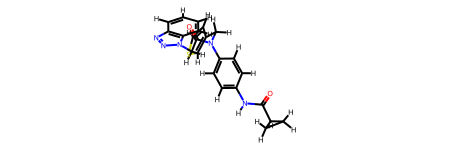

In [62]:
# Check our molecule from RDKit. Doesn't have rotation, but its neat to see in a Jupyer Notebook for just invoking it
corrected_pose_with_H

RDKit can help us generate tautomers, however, RDKit also works on the principal that hydrogens are generally implicit (i.e. `removeHs=True`, default). If you leave hydrogens in your structure, [you can get some very odd and incorrect results depending on what you are doing](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html#rdkit.Chem.rdmolops.AddHs). So we'll work with the structure before we added hydrogens.

In [ ]:
# @title
%%html
<style>
div.info { /* Based on Bootstrap Secondary Alert */
    color: #0c5460; /* Darker shade of blue for text */
    background-color: #d1ecf1; /* Light blue background */
    border-left: 5px solid #459db9; /* Bright blue border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="info">

<strong>RDKit's Tautomer Enumeration routine generates ALL POSSIBLE tautomers</strong>

<p>Not all tautomers are stable, or even energetically favored, especially with at certain pH. Without additional logic and code, this is just a set of all possible ones.

</div>

Further Reading: [RDKit has a blogpost](https://rdkit.blogspot.com/2020/01/trying-out-new-tautomer.html) with a helpful function to re-order tautomers with the canonical one first. Take a look if you're interested. Note: ["Canonical" does not mean most stable, and is likely not the most stable](https://www.rdkit.org/docs/cppapi/classRDKit_1_1MolStandardize_1_1TautomerEnumerator.html#a7e4f2a393b92f09ee1447d2af50918dc).

In [63]:
from rdkit.Chem.MolStandardize import rdMolStandardize
# Initialize enumerator
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
# Provide RDKit Mol object to generate.
# We already made this, but you may start from a SMILE string or other source
# Remember, use the structure with implicit hydrogens!
tautomers = tautomer_enumerator.Enumerate(corrected_pose)
# Take the TautomerEnumerationResults object and iterate over to get a list of structures
tautomers_list = [t for t in tautomers]

'''
Note! This may generate duplicate structures,
You may want to cast these Mol objects into SMILES strings, de-duplicate,
then rebuild the Mol objects to map their coordinates back onto the reference structure
'''

# Cast to a set to make unique, then back to a list (as some tautomers can be enumerated again for some structures)
smiles_set_tautomers = set(Chem.MolToSmiles(t) for t in tautomers_list)
tautomer_list_unique = list(smiles_set_tautomers)
# We know the Y6J structure does have unique tautomers, this is just a sanity check
assert len(tautomers_list) == len(tautomer_list_unique)

In [64]:
ligand_tautomers = f"{ligand_directory}/{ligand_id}_tautomers.sdf"
writer = Chem.SDWriter(ligand_tautomers)
for t in tautomers_list:
  writer.write(t)
writer.close()

Rendering all these tautomers at once in 3D, or looking through the SDF file isn't going to show many differences, so let's instead just look at the SMILES strings.

In [65]:
for t in tautomer_list_unique:
  print(t)

O=C(Cn1nnc2ccccc21)N(Cc1ccsc1)c1ccc(N=C(O)C2CC2)cc1
O=C(Nc1ccc(N(Cc2ccsc2)C(=O)Cn2nnc3ccccc32)cc1)C1CC1
O=C(Nc1ccc(N(Cc2ccsc2)C(O)=Cn2nnc3ccccc32)cc1)C1CC1
OC(=Cn1nnc2ccccc21)N(Cc1ccsc1)c1ccc(N=C(O)C2CC2)cc1
OC(=Cn1nnc2ccccc21)N(Cc1ccsc1)c1ccc(NC(O)=C2CC2)cc1
O=C(Cn1nnc2ccccc21)N(Cc1ccsc1)c1ccc(NC(O)=C2CC2)cc1


However, rendering their 2D smiles strings can be done with a built-in RDKit module and function. Neat!

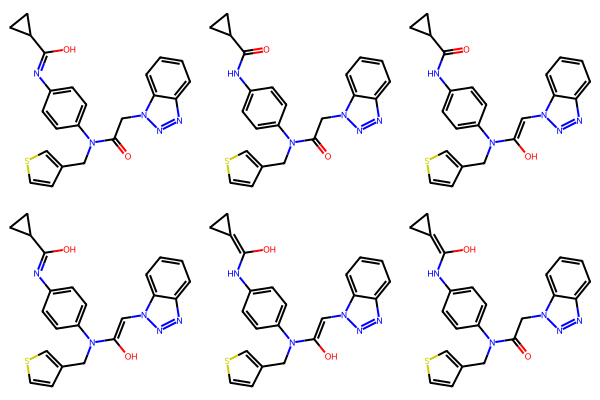

In [66]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(t) for t in tautomer_list_unique])

In [ ]:
# @title
%%html
<style>
div.warning { /* Based on Bootstrap Warning */
    color: #856404; /* Darker shade of yellow-brown for text */
    background-color: #fff3cd; /* Light faded yellow background */
    border-left: 5px solid #fad975; /* saturated yellow border */
    padding: 0.5em;
    font-size: 1.25em; /* Matches the surrounding text size */
    line-height: 1.5; /* Ensures readability */
}
div.info ul {
    margin: 0.5em 0; /* Space around the list */
}
div.info li {
    margin-bottom: 0.5em; /* Space between list items */
}
</style>

<div class="warning">

<strong>SMILES strings from explicit hydrogen structures breaks RDKit</strong>

<p>If we made the tautomers with explicit hydrogens, we would have made 24 and RDKit could not have rebuilt the Mol objects from the strings; throwing errors because of too many valence electrons.

</div>

We've now generated many tautomers we could use for docking. The good news is, many docking codes, including `gnina` will accept multi-ligand input files for us. We could convert the SDF file into a set of PDBQT files for `gnina` like we did with `OpenBabel`, but consider that we've only enumerated *all* tautomers, not the most likely ones for pH. We could do that with `RDKit` and our own logic, or we can use `Scrubber` which has a handy command-line utility we can just call.

In [67]:
print(f"{ligand_directory}/{ligand_id}_corrected_pose.sdf")
print(f"{ligand_directory}/{ligand_id}.pdbqt")

ligand_structures/Y6J_corrected_pose.sdf
ligand_structures/Y6J.pdbqt


In [68]:
!scrub.py ligand_structures/Y6J_corrected_pose.sdf -o ligand_structures/Y6J.sdf

Scrub completed.
Summary of what happened:
Input molecules supplied: 1
mols processed: 1, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 1 (avg. 1.000 per mol)
nr conformers:  1 (avg. 1.000 per isomer, 1.000 per mol)


Scrubber took a pre-set pH, did the following actions for us (from [their documentation](https://github.com/forlilab/molscrub)) using RDKit under the hood:
* Generate 3D coordinates using RDKit's ETKDGv3 and UFF minimization
* Enumerate tautomers (aiming at low energy states only)
* Enumerate pH corrections
* Convert boats to chairs (6-member rings) and enumerate both chair states

There are plenty of command line options and a Python API for Scrubber as well.

And now with our SDF file which has been "scrubbed," we can finally generate our ready-to-feed-into `gnina` PDBQT file that we'll use for docking.

In [69]:
# Create our PDBQT to keep our hydrogens
ligand_pdbqt_filename = f"{ligand_directory}/{ligand_id}.pdbqt"
os.system(f"obabel {ligand_corrected_pose_file} -O {ligand_pdbqt_filename} -xh")

0

And now we have 1 ligand ready to go for docking. But what if we want to have multiple ligands, such as the ones we made from the [second notebook of this workshop?](https://colab.research.google.com/github/MolSSI-Education/iqb-2025/blob/main/02_Cheminfo_crash_course.ipynb)

## Preparing multiple ligands from SMILES strings

If you want to upload your own CSV file of SMILES strings, feel free to do so. Or you can pull down a sample output by running the code below. There are other codes which can go about this, but this is one example where we can prep from data we've already worked with.

In [70]:
# Run this cell if you want some sample SMILE strings from the
# US20240293380 set for 7LME docking. You can also use your own.
!wget https://github.com/MolSSI-Education/iqb-2025/raw/refs/heads/main/data/US20240293380_examples.csv

--2025-05-01 20:00:51--  https://github.com/MolSSI-Education/iqb-2025/raw/refs/heads/main/data/US20240293380_examples.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MolSSI-Education/iqb-2025/refs/heads/main/data/US20240293380_examples.csv [following]
--2025-05-01 20:00:51--  https://raw.githubusercontent.com/MolSSI-Education/iqb-2025/refs/heads/main/data/US20240293380_examples.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 512 [text/plain]
Saving to: ‘US20240293380_examples.csv’

US20240293380_examp 100%[===================>]     512  --.-KB/s    in 0s      

2025-05-01 20:00:51 (27.0 

We'll be using RDKit to pull these SMILES strings back into `Mol` objects (which if we were doing this whole workshop in one notebook we could have skipped), then casting the molecules to SDF, and then back into 3D structures with `Scrubber`. The back and forth between the programs may seem a bit silly because we had the `Mol` objects earlier, but sometimes you will only have SMILE strings to start your research, so we'll work from that basis here.

In [71]:
# Load the SMILES strings into RDKit and write back out an SDF file.
# Default delimiter is tab (\t), so we need to specify ","
smiles_supplier = Chem.SmilesMolSupplier("US20240293380_examples.csv", delimiter=",")
mols = []  # Could do this in list comprehension, adding a sanity check
for mol in smiles_supplier:
  print(Chem.MolToSmiles(mol))  # Sanity check that we got the smiles strings and not metadata
  mols.append(mol)

# Write out our molecules
ligands_to_dock_dirty = f"{ligand_directory}/ligands_to_dock_dirty.sdf"
writer = Chem.SDWriter(ligands_to_dock_dirty)
for m in mols:
  writer.write(m)
writer.close()

O=C(Cc1cncc2ccccc12)N(Cc1cc(F)cc(Cl)c1)c1ccc(-c2c[nH]cn2)cc1
O=C(Cc1nnc2ccccn12)N(Cc1cccc(Cl)c1)c1ccc(-c2cn[nH]c2)cc1
CC(C)(C)NC(=O)C(c1cc(F)cc(F)c1)N(C(=O)Cc1cncc2ccccc12)c1ccc(C2=CCNC2)cc1
O=C(Cc1cncc(F)c1)N(Cc1cncc(F)c1)c1ccc(C2CNC2)cc1
O=C(Cc1cnc2ccccn12)N(Cc1cccc(Cl)c1)c1ccc(-c2cn[nH]c2)cc1


The file is labeled as "dirty" since there is more preparation work to do before these molecules are ready to insert into docking. Because we started with SMILES, we got a 2D structure by default with RDKit. we can see that by just declaring the most recent `mol` object from our list.

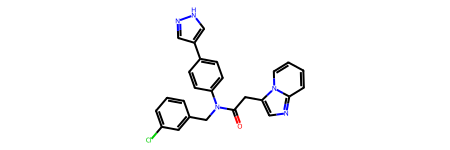

In [72]:
mol

We can also see that there are some erroneous fields here because we did a very, very simple read of the CSV file with our SMILES strings. We don't need that information here, but you might in the future; make sure you parse your data correctly as needed. (e.g. with the Python built-in `csv` module or manipulate the Pandas `DataFrame` directly). We'll use `Scrubber` to clean up our structures for us all at once.

In [73]:
!scrub.py ligand_structures/ligands_to_dock_dirty.sdf -o ligand_structures/ligands_to_dock.sdf

Scrub completed.
Summary of what happened:
Input molecules supplied: 5
mols processed: 5, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 6 (avg. 1.200 per mol)
nr conformers:  6 (avg. 1.000 per isomer, 1.200 per mol)


We got some text output, but did that do what we wanted? We could assume we did, or we can make sure.

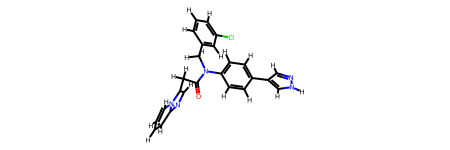

In [74]:
# Sanity check we got a structure with hydrogens
# RDKit automatically removes hydrogens by default (needed for most of the kit to work)
# But we're explicitly looking for them here, we can just load them and check
supplier = Chem.SDMolSupplier(f"{ligand_directory}/ligands_to_dock.sdf", removeHs=False)
reloaded_ligands = [mol for mol in supplier]
# The last structure will be the same as the last in list comprehension above
reloaded_ligands[-1]

Our receptor, experimental ligand, and additional ligands have now been downloaded, separated, cleaned, and modified starting from both a single structure on the RCSB and through BindingDB. We applied our bioinformatics and molecular modeling tools to create computational-ready models that we will now feed into docking.